# ISYE 6501 - Homework 5

## **Question 11.1**: Regression Modeling on the `uscrime` Dataset

**Goals:**
1. Stepwise regression (forward, backward, both)
2. Lasso (α = 1)
3. Elastic Net (0 ≤ α ≤ 1)

### 1. Setup

In [11]:
## 1. Setup ------------------------------------------------------------------

# 1.1 Load required libraries
library(MASS) # stepAIC
library(glmnet) # lasso / elastic net

# Install and load FrF2 with error handling
if (!require(FrF2, quietly = TRUE)) {
    cat("Installing FrF2 package...\n")
    install.packages("FrF2", dependencies = TRUE)
    library(FrF2)
}

# Check if FrF2 loaded successfully
if (!"FrF2" %in% loadedNamespaces()) {
    stop("FrF2 package failed to load. Please install manually.")
} else {
    cat("FrF2 package loaded successfully.\n")
}

# 1.2 Load data
crime <- read.table("uscrime.txt", header = TRUE)
head(crime)
str(crime)

# 1.3 Define response & predictors
response <- "Crime"
predictors <- setdiff(names(crime), response)
y <- crime[[response]]
x <- as.matrix(crime[, predictors])


FrF2 package loaded successfully.


,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>
1,15.1,1,9.1,5.8,5.6,0.510,95.0,33,30.1,0.108,4.1,3940,26.1,0.084602,26.2011,791
2,14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096,3.6,5570,19.4,0.029599,25.2999,1635
3,14.2,1,8.9,4.5,4.4,0.533,96.9,18,21.9,0.094,3.3,3180,25.0,0.083401,24.3006,578
4,13.6,0,12.1,14.9,14.1,0.577,99.4,157,8.0,0.102,3.9,6730,16.7,0.015801,29.9012,1969
5,14.1,0,12.1,10.9,10.1,0.591,98.5,18,3.0,0.091,2.0,5780,17.4,0.041399,21.2998,1234
6,12.1,0,11.0,11.8,11.5,0.547,96.4,25,4.4,0.084,2.9,6890,12.6,0.034201,20.9995,682


'data.frame':	47 obs. of  16 variables:
 $ M     : num  15.1 14.3 14.2 13.6 14.1 12.1 12.7 13.1 15.7 14 ...
 $ So    : int  1 0 1 0 0 0 1 1 1 0 ...
 $ Ed    : num  9.1 11.3 8.9 12.1 12.1 11 11.1 10.9 9 11.8 ...
 $ Po1   : num  5.8 10.3 4.5 14.9 10.9 11.8 8.2 11.5 6.5 7.1 ...
 $ Po2   : num  5.6 9.5 4.4 14.1 10.1 11.5 7.9 10.9 6.2 6.8 ...
 $ LF    : num  0.51 0.583 0.533 0.577 0.591 0.547 0.519 0.542 0.553 0.632 ...
 $ M.F   : num  95 101.2 96.9 99.4 98.5 ...
 $ Pop   : int  33 13 18 157 18 25 4 50 39 7 ...
 $ NW    : num  30.1 10.2 21.9 8 3 4.4 13.9 17.9 28.6 1.5 ...
 $ U1    : num  0.108 0.096 0.094 0.102 0.091 0.084 0.097 0.079 0.081 0.1 ...
 $ U2    : num  4.1 3.6 3.3 3.9 2 2.9 3.8 3.5 2.8 2.4 ...
 $ Wealth: int  3940 5570 3180 6730 5780 6890 6200 4720 4210 5260 ...
 $ Ineq  : num  26.1 19.4 25 16.7 17.4 12.6 16.8 20.6 23.9 17.4 ...
 $ Prob  : num  0.0846 0.0296 0.0834 0.0158 0.0414 ...
 $ Time  : num  26.2 25.3 24.3 29.9 21.3 ...
 $ Crime : int  791 1635 578 1969 1234 682 963 1555 

---
## 2. Stepwise Regression
We fit three variants via AIC: forward, backward, and both.

In [12]:
## 2. Stepwise Regression Analysis ------------------------------------------

## 2.1 Full and Null Models
full_mod <- lm(Crime ~ ., data = crime)
null_mod <- lm(Crime ~ 1, data = crime)

## 2.2 Stepwise Methods
step_fwd <- stepAIC(null_mod,
    scope = list(lower = null_mod, upper = full_mod),
    direction = "forward", trace = FALSE
)
step_bwd <- stepAIC(full_mod, direction = "backward", trace = FALSE)
step_both <- stepAIC(null_mod,
    scope = list(lower = null_mod, upper = full_mod),
    direction = "both", trace = FALSE
)

## 2.3 Results Summary
stepwise_results <- data.frame(
    Method = c("Full", "Forward", "Backward", "Both"),
    Variables = c(
        length(coef(full_mod)) - 1,
        length(coef(step_fwd)) - 1,
        length(coef(step_bwd)) - 1,
        length(coef(step_both)) - 1
    ),
    AIC = round(c(AIC(full_mod), AIC(step_fwd), AIC(step_bwd), AIC(step_both)), 1),
    Adj_R2 = round(c(
        summary(full_mod)$adj.r.squared,
        summary(step_fwd)$adj.r.squared,
        summary(step_bwd)$adj.r.squared,
        summary(step_both)$adj.r.squared
    ), 3)
)

print(stepwise_results)

# Best model
best_idx <- which.min(stepwise_results$AIC[-1]) + 1
# Exclude full model from comparison
cat(
    "\nBest model:", stepwise_results$Method[best_idx],
    "| AIC:", stepwise_results$AIC[best_idx],
    "| Adj R²:", stepwise_results$Adj_R2[best_idx], "\n"
)

# Selected variables for best model
best_model <- list(step_fwd, step_bwd, step_both)[[best_idx - 1]]
cat("Variables:", paste(names(coef(best_model))[-1], collapse = ", "), "\n")


    Method Variables   AIC Adj_R2
1     Full        15 650.0  0.708
2  Forward         6 640.2  0.731
3 Backward         8 639.3  0.744
4     Both         6 640.2  0.731

Best model: Backward | AIC: 639.3 | Adj R²: 0.744 
Variables: M, Ed, Po1, M.F, U1, U2, Ineq, Prob 


---
## 3. Lasso Regression (α = 1)
We’ll standardize predictors and use `cv.glmnet` to pick λ via 10-fold CV.

Lasso Results:
Optimal λ: 3.3199 
Variables selected: 12 
Selected variables: M, So, Ed, Po1, M.F, Pop, NW, U1, U2, Wealth, Ineq, Prob 


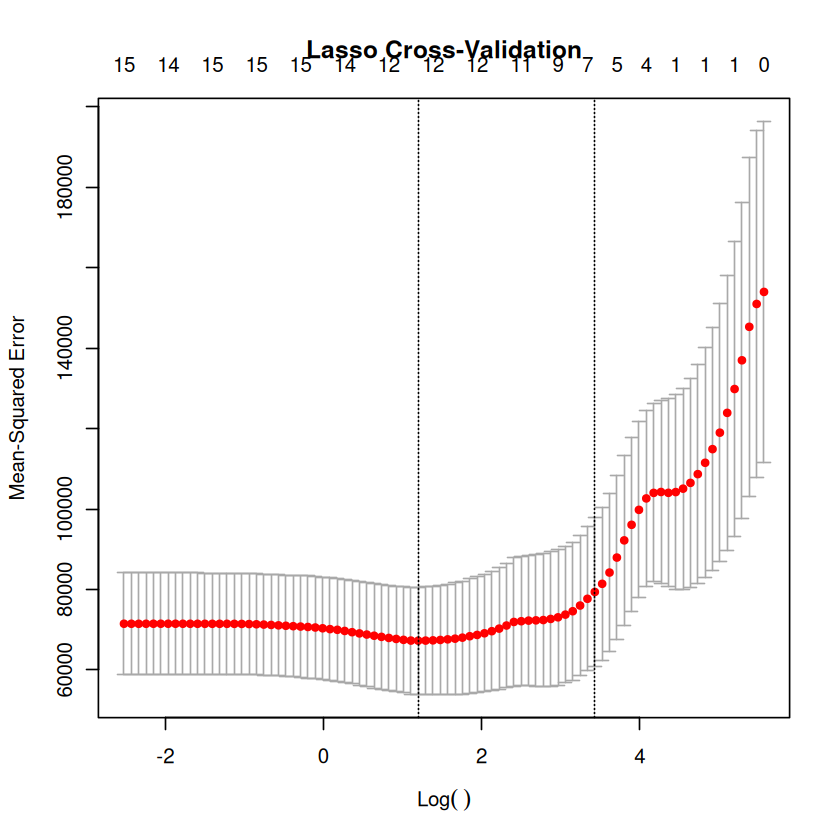

In [13]:
## 3. Lasso Regression (α = 1) ----------------------------------------------

## 3.1 Scale predictors and fit CV Lasso
x_scaled <- scale(x)
set.seed(123)
cv_lasso <- cv.glmnet(x_scaled, y, alpha = 1, nfolds = 10)

## 3.2 Results
best_lambda <- cv_lasso$lambda.min
lasso_mod <- glmnet(x_scaled, y, alpha = 1, lambda = best_lambda)

# Extract non-zero coefficients
lasso_coefs <- coef(lasso_mod)
selected_vars <- rownames(lasso_coefs)[lasso_coefs[, 1] != 0][-1] # Exclude intercept

cat("Lasso Results:\n")
cat("Optimal λ:", round(best_lambda, 4), "\n")
cat("Variables selected:", length(selected_vars), "\n")
cat("Selected variables:", paste(selected_vars, collapse = ", "), "\n")

# Optional: Show plot
plot(cv_lasso, main = "Lasso Cross-Validation")


---
## 4. Elastic Net Regression
We’ll sweep α from 0 (ridge) to 1 (lasso) in steps of 0.1, pick the best (α,λ) by CV MSE, then refit.

In [14]:
## 4. Elastic Net Regression ------------------------------------------------

## 4.1 Grid Search over α
alpha_vals <- seq(0, 1, by = 0.1)
set.seed(123)

# Find best alpha-lambda combination
best_cvm <- Inf
best_alpha <- NA
best_lambda <- NA

for (a in alpha_vals) {
  cv <- cv.glmnet(x_scaled, y, alpha = a, nfolds = 10)
  if (min(cv$cvm) < best_cvm) {
    best_cvm <- min(cv$cvm)
    best_alpha <- a
    best_lambda <- cv$lambda.min
  }
}

## 4.2 Final Elastic Net Fit
enet_mod <- glmnet(x_scaled, y, alpha = best_alpha, lambda = best_lambda)
enet_coefs <- coef(enet_mod)
selected_vars <- rownames(enet_coefs)[enet_coefs[, 1] != 0][-1] # Exclude intercept

cat("Elastic Net Results:\n")
cat("Best α:", best_alpha, "| Best λ:", round(best_lambda, 4), "\n")
cat("Variables selected:", length(selected_vars), "\n")
cat("Selected variables:", paste(selected_vars, collapse = ", "), "\n")


Elastic Net Results:
Best α: 0.8 | Best λ: 12.6731 
Variables selected: 12 
Selected variables: M, So, Ed, Po1, LF, M.F, NW, U1, U2, Wealth, Ineq, Prob 


---

## **Question 12.1**

Describe a situation or problem from your job, everyday life, current events, etc., for which a design of experiments approach would be appropriate.


**Answer:**

- **Marketing Email Optimization (Job Context):** At GEICO, we might want to optimize the impact of promotional emails. We can use a factorial design varying **subject line length** (short vs. long), **send time** (morning vs. afternoon), and **call-to-action color** (blue vs. green). By systematically testing all combinations, we can measure open rates and click-through rates to identify the most effective factors and interactions.

- **Baking Recipe Experiment (Everyday Life):** When perfecting a cake, you could vary **oven temperature** (325°F vs. 350°F) and **bake time** (25 vs. 30 minutes) in a two-factor design. Measuring texture and moistness for each combination helps determine the optimal settings without testing every possible time–temperature pair ad hoc.

- **Vaccine Dosage Study (Current Events):** In clinical trials, a DOE approach can test different **dosages** and **adjuvant types** to evaluate efficacy and side effects. A randomized block or factorial design ensures reliable estimation of main and interaction effects.



---

## **Question 12.2**

To determine the value of 10 different yes/no features to the market value of a house (large yard, solar roof, etc.), a real estate agent plans to survey 50 potential buyers, showing a fictitious house with different combinations of features. To reduce the survey size, the agent wants to show just 16 fictitious houses. Use R’s `FrF2` function (in the `FrF2` package) to find a fractional factorial design for this experiment: what set of features should each of the 16 fictitious houses have?  Note: the output of `FrF2` is `1` (include) or `-1` (don’t include) for each feature.

In [15]:
# Define 10 yes/no factors
factors <- paste0("F", 1:10)

# Generate a 2^(10-6) fractional factorial design (16 runs)
design <- FrF2(nruns = 16, nfactors = 10, factor.names = factors)

# Display the design (1 = include feature, -1 = exclude feature)
print(design)


   F1 F2 F3 F4 F5 F6 F7 F8 F9 F10
1   1  1 -1 -1  1 -1 -1 -1  1   1
2  -1 -1  1  1  1 -1 -1 -1 -1   1
3  -1  1 -1 -1 -1  1 -1  1  1  -1
4  -1  1  1 -1 -1 -1  1  1 -1   1
5  -1 -1 -1 -1  1  1  1  1 -1   1
6   1 -1  1 -1 -1  1 -1 -1  1   1
7   1 -1 -1  1 -1 -1  1  1  1   1
8   1  1 -1  1  1 -1 -1  1 -1  -1
9  -1  1  1  1 -1 -1  1 -1  1  -1
10 -1 -1  1 -1  1 -1 -1  1  1  -1
11 -1  1 -1  1 -1  1 -1 -1 -1   1
12  1 -1 -1 -1 -1 -1  1 -1 -1  -1
13 -1 -1 -1  1  1  1  1 -1  1  -1
14  1  1  1 -1  1  1  1 -1 -1  -1
15  1  1  1  1  1  1  1  1  1   1
16  1 -1  1  1 -1  1 -1  1 -1  -1
class=design, type= FrF2 


**Answer**

Based on the output from the cell above:

- **House 1**: Should include features F1, F2, F5, F9, and F10. It should exclude features F3, F4, F6, F7, and F8.
- **House 2**: Should include features F3, F4, F5, and F10. It should exclude features F1, F2, F6, F7, F8, and F9.
- **House 12**: Should only include feature F1 and exclude all others.
- **House 15**: Should include all 10 features.

---

## **Question 13.1**

For each distribution below, give an example of data you would expect to follow it (besides the examples discussed in class):

-  Binomial  
-  Geometric  
-  Poisson  
-  Exponential  
-  Weibull

**Answer:**
- **Binomial**: The number of patients who respond positively to a new drug in a clinical trial of 20 participants.
- **Geometric**: The number of job applications a person submits before receiving their first interview offer.
- **Poisson**: The number of mutations in a specific gene sequence of a given length.
- **Exponential**: The time until the next earthquake occurs in a specific region.
- **Weibull**: The wind speed distribution for a particular location, often used for wind power assessment.